<a href="https://colab.research.google.com/github/zahraDehghanian97/Brain_cancer_classification/blob/master/Brain_Tumor_MRI_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Detection and Classification of Brain Tumor through Brain MRI Images Using Deep Learning**  

## **1.Introduction**  

* The occurrence of brain tumor patients in India is steadily rising,
more and more number of cases are reported each year in India across
various age groups.  

* The [International Association of Cancer Registries (IARC)](https://cutt.ly/Wc4DaIE) reported
that there are over $28,000$ cases of brain tumours reported in India
each year and more than $24,000$ people reportedly i.e. $85.72\%$ of the
total reported die due to brain tumours annually. Brain tumour’s are
a serious condition and in most cases fatal if not detected & treated
in early stages.



## **2. Setting Up Local Storage for Dataset**

### **2.1 Giving Access To Google Drive**

In [1]:
#Connect Google Drive to Colab

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **3. Importing Required Libraries**

In [3]:
import sys
import os
import math
import numpy as np
import pandas as pd
import h5py
from matplotlib import pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from PIL import Image
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['figure.dpi'] = 300
%matplotlib inline
import seaborn as sns
import missingno as msno
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import *
from PIL import Image, ImageEnhance
from tensorflow.keras.preprocessing.image import *

## **5. Data Preprocessing and Exploratory Data Analysis**

In [45]:
def mat_file_to_dict(filepath: str) -> dict:
    tumor_class = {1: 'meningioma', 2: 'glioma', 3: 'pituitary_tumor'}
    tumor_data_dict = {}
    with h5py.File(filepath, mode = 'r') as image_data:
        cjdata_struct = image_data['cjdata']
        id  = ""
        for i in range (len(cjdata_struct['PID'])):
          id = id+str(cjdata_struct['PID'][i][0])
        tumor_data_dict['PID'] = int(id)
        tumor_data_dict['class'] = tumor_class[int(cjdata_struct['label'][0, 0])]
        tumor_data_dict['image'] = cjdata_struct['image'][:].transpose()
        tumor_data_dict['tumor_border'] = cjdata_struct['tumorBorder'][0]
        tumor_data_dict['tumor_mask'] = cjdata_struct['tumorMask'][:].transpose()
    return tumor_data_dict

data = []
rootpath_dataset = '/content/drive/My Drive/Colab Notebooks/Brain Cancer'
mat_dirname = 'Mat Files'
# training_dir = os.path.join(rootpath_dataset, 'Training')
m_count, g_count, p_count = (0, 0, 0)
c = 500
for root, dirpath, filenames in os.walk(os.path.join(rootpath_dataset, mat_dirname)):
    for curr_file in filenames:
      if c>0 :
        mri_img_data = mat_file_to_dict(os.path.join(root, curr_file))
        data.append(mri_img_data)
        c=c-1
df_images = pd.DataFrame(data)

In [46]:
df_images.head()

,PID,class,image,tumor_border,tumor_mask
0,494851565155,pituitary_tumor,"[[1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,...","[210.50871080139373, 299.7073170731707, 218.53...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,494851495256,glioma,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[220.20988307196188, 279.9185329596331, 231.16...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,494854525752,glioma,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[165.0097586191287, 265.84905555304067, 167.45...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,494854525752,glioma,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[122.81657396305157, 243.83583220957067, 128.8...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,494854525752,glioma,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[181.04999243242156, 187.19675143475686, 179.3...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


### **5.2 Visualisation of Brain MRI Dataset**

In [47]:
def generate_img_from_mat(mat_file_data) :
    plt.figure(figsize = (6, 3))
    tumor_mri = plt.imshow(mat_file_data['image'], cmap = 'gray')
    plt.title(mat_file_data['class'])
    plt.axis('off')
    plt.show()
def generate_img_from_list(mat_file_list):
    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (6,3))
    axes = axes.flatten()
    c = 0
    for curr_axis in axes[:2] :
      curr_axis.imshow(mat_file_list['image'][c], cmap = 'gray')
      curr_axis.set_title(mat_file_list['class'][c], fontsize = 14)
      c+=1
  

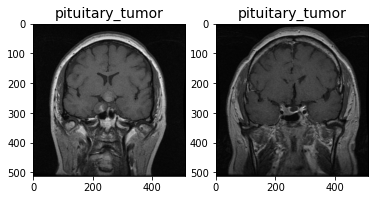

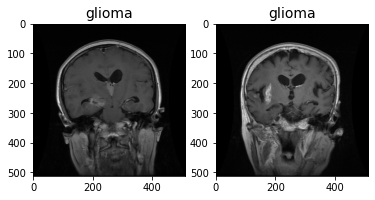

In [48]:
labels = set(df_images['class'])
sample_images = []
for i in labels :
  df_t =df_images.loc[df_images['class'] == i].reset_index(drop=True)
  if len(df_t)>1 :
    generate_img_from_list(df_t.loc[0:1])
  else :
    generate_img_from_mat(df_t.loc[0])
 


### **6. Development of Training, Validation & Testing Dataset**

In [49]:
train_data, validation_data = train_test_split(df_images,
                                               train_size = 0.80, 
                                               random_state = 42, 
                                               stratify = df_images['class'])

### **6.1 Training, Validation and Testing Dataset Data Distribution Visualization**

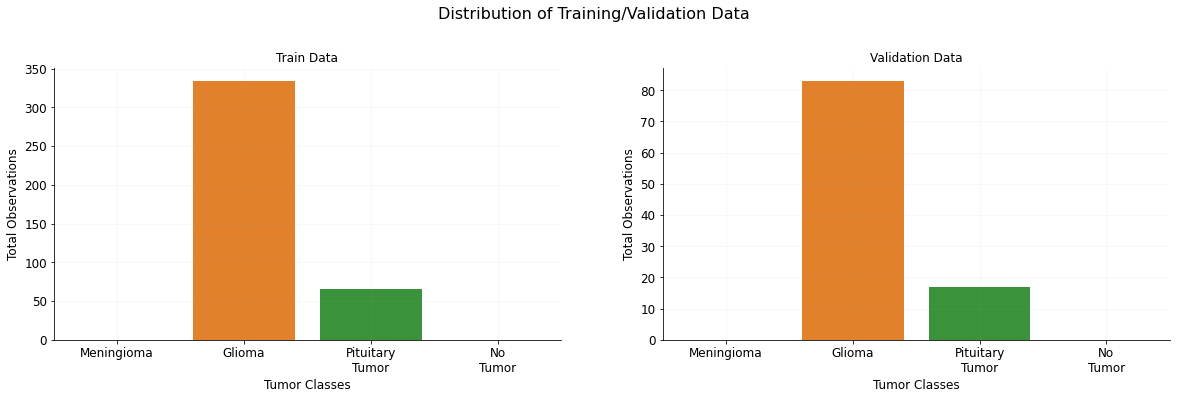

In [51]:
fig, axes = plt.subplots(ncols = 2, figsize = (20, 5))
TUMOR_CLASS = ['meningioma', 'glioma', 'pituitary_tumor', 'no_tumor']
fig.suptitle("Distribution of Training/Validation Data", fontsize = 16, fontdict = dict(weight = 'bold'), y = 1.05)
sns.countplot(x = train_data['class'], order = TUMOR_CLASS, ax = axes[0])
sns.countplot(x = validation_data['class'], order = TUMOR_CLASS, ax = axes[1])
for curr_axis, curr_title in zip(axes, ['Train Data', 'Validation Data']):
    curr_axis.grid(False, alpha = 0.1)
    curr_axis.set_title(curr_title, fontsize = 12)
    curr_axis.set_xlabel("Tumor Classes", fontsize = 12)
    curr_axis.set_ylabel("Total Observations", fontsize = 12)
    curr_axis.tick_params(which = 'major', labelsize = 12)
    curr_axis.set_xticklabels(["\n".join(xtick.split("_")).title() for xtick in TUMOR_CLASS])
sns.despine()

## **7. Data/Image Augmentation**
* Image augmentation is usually used to increase the image dataset and also to make the network more robust against translation invariance. Image augmentation is defined as creating duplicates of the original image datasets by flipping, rotating, zooming, and adjusting brightness. 

* We will use data/image augmentation using `ImageDataGenerator` class to train the model on different types of combinations formed by rotation, flipping, changing the brightness etc of an image so as to increase our model accuracy.

In [52]:
image_size = 128
batch_size = 32

image_datagen_kwargs = dict(rescale = 1 / 255,
                            rotation_range = 15, 
                            width_shift_range = 0.1, 
                            zoom_range = 0.01, 
                            shear_range = 0.01,
                            brightness_range = [0.3, 1.5],
                            horizontal_flip = True,
                            vertical_flip = True)

In [53]:
train_image_datagen = ImageDataGenerator(**image_datagen_kwargs)
validation_image_datagen = ImageDataGenerator(**image_datagen_kwargs)

In [57]:
train_dataset = train_image_datagen.flow_from_dataframe(train_data, 
                                                        x_col = 'image', 
                                                        y_col = 'class', 
                                                        seed = 42, 
                                                        batch_size = batch_size,
                                                        target_size = (image_size, image_size),
                                                        color_mode = 'rgb')
validation_dataset = validation_image_datagen.flow_from_dataframe(validation_data, 
                                                                  x_col = 'image', 
                                                                  y_col = 'class', 
                                                                  seed = 42,
                                                                  batch_size = batch_size, 
                                                                  target_size = (image_size, image_size),
                                                                  color_mode = 'rgb')


TypeError: ignored

In [ ]:
print("Information about Training Dataset:")
print(train_dataset.class_indices)
print(train_dataset.image_shape, end = '\n\n')
 
print("Information about Validation Dataset:")
print(validation_dataset.class_indices)
print(validation_dataset.image_shape, end = '\n\n')
 

Information about Training Dataset:
{'glioma': 0, 'meningioma': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
(128, 128, 3)

Information about Validation Dataset:
{'glioma': 0, 'meningioma': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
(128, 128, 3)

Information about Testing Dataset:
{'glioma': 0, 'meningioma': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
(128, 128, 3)


### **7.1 Training Data Images Glimpse**

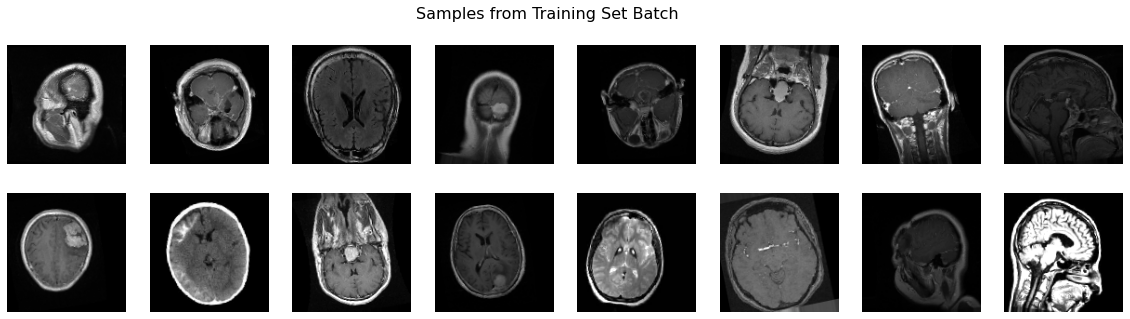

In [ ]:
fig, axes = plt.subplots(nrows = 2, ncols = 8, figsize = (20, 5))
fig.suptitle("Samples from Training Set Batch", fontsize = 16, fontdict = dict(weight = 'bold'))
for curr_axis, curr_image in zip(axes.flatten(), train_dataset[0][0][:16]):
    curr_axis.imshow(tf.squeeze(curr_image), cmap = 'gray')
    curr_axis.axis(False)

### **7.2 Validation Data Images Glimpse**

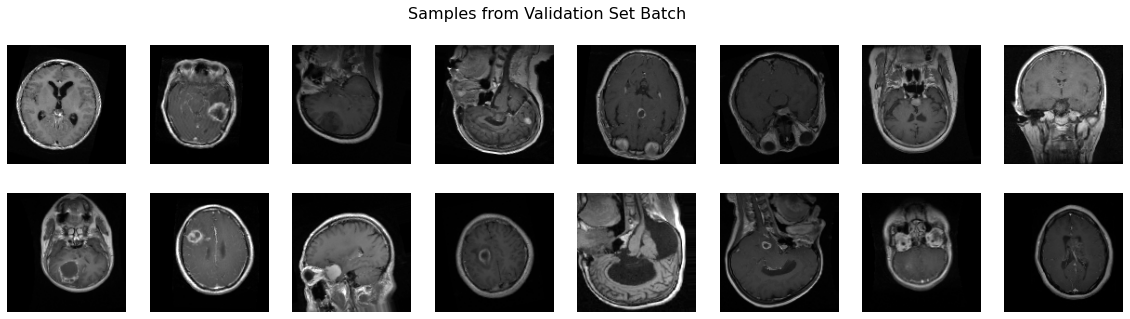

In [ ]:
fig, axes = plt.subplots(nrows = 2, ncols = 8, figsize = (20, 5))
fig.suptitle("Samples from Validation Set Batch", fontsize = 16, fontdict = dict(weight = 'bold'))
for curr_axis, curr_image in zip(axes.flatten(), validation_dataset[0][0][:16]):
    curr_axis.imshow(tf.squeeze(curr_image), cmap = 'gray')
    curr_axis.axis(False)

### **7.3 Testing Data Images Glimpse**

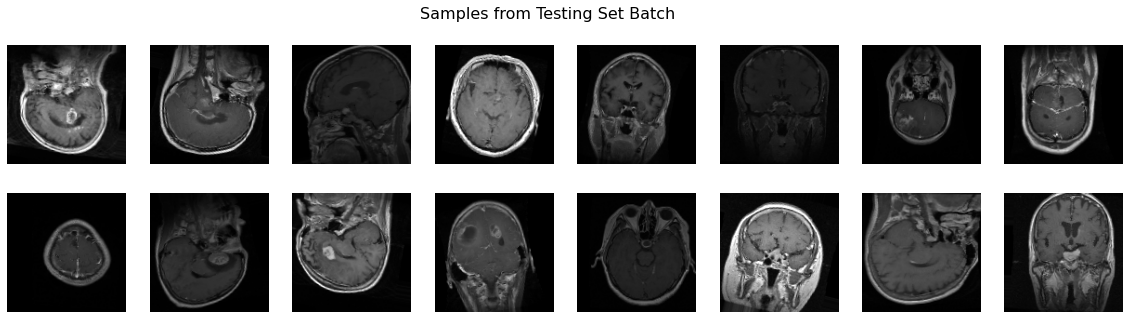

In [ ]:
fig, axes = plt.subplots(nrows = 2, ncols = 8, figsize = (20, 5))
fig.suptitle("Samples from Testing Set Batch", fontsize = 16, fontdict = dict(weight = 'bold'))
for curr_axis, curr_image in zip(axes.flatten(), test_dataset[0][0][:16]):
    curr_axis.imshow(tf.squeeze(curr_image), cmap = 'gray')
    curr_axis.axis(False)

## **8. Model Development**

In [ ]:
early_stopping = EarlyStopping(monitor = 'val_accuracy', patience = 10)

In [ ]:
ROOT_CHECKPOINT_DIR_PATH = os.path.join(ROOT_DIR, "Model-Checkpoints")
MLP_CHECKPOINT_DIR_PATH = os.path.join(ROOT_CHECKPOINT_DIR_PATH, "Multi-Layer-Perceptron")
ALEXNET_CHECKPOINT_DIR_PATH = os.path.join(ROOT_CHECKPOINT_DIR_PATH, "AlexNet-CNN")
INCEPTIONV3_CHECKPOINT_DIR_PATH = os.path.join(ROOT_CHECKPOINT_DIR_PATH, "InceptionV3")
assert os.path.isdir(ROOT_CHECKPOINT_DIR_PATH) and os.path.isdir(MLP_CHECKPOINT_DIR_PATH) and os.path.isdir(ALEXNET_CHECKPOINT_DIR_PATH) and os.path.isdir(INCEPTIONV3_CHECKPOINT_DIR_PATH)

In [ ]:
mlp_cp_callback = ModelCheckpoint(MLP_CHECKPOINT_DIR_PATH, 
                                  monitor = 'val_accuracy', 
                                  verbose = 1, 
                                  save_weights_only = True, 
                                  save_freq =  'epoch')

alexnet_cp_callback = ModelCheckpoint(ALEXNET_CHECKPOINT_DIR_PATH, 
                                      monitor = 'val_accuracy', 
                                      verbose = 1, 
                                      save_weights_only = True, 
                                      save_freq = 'epoch')

inceptionv3_cp_callback = ModelCheckpoint(INCEPTIONV3_CHECKPOINT_DIR_PATH, 
                                          monitor = 'val_accuracy', 
                                          verbose = 1, 
                                          save_weights_only = True, 
                                          save_freq = 'epoch')

In [ ]:
def training_process_viz(training_stats: pd.DataFrame, **plot_kwargs) -> None:
    fig, axes = plt.subplots(ncols = 2, figsize = (15, 5))
    fig.suptitle(plot_kwargs['plot_title'], fontsize = 16, fontdict = dict(weight = 'bold'), y = 1.08)
    for curr_axis, col_name in zip(axes, ['accuracy', 'loss']):
        curr_axis.grid(True, alpha = 0.3)
        curr_axis.set_title(f"Model {col_name}".title(), fontsize = 14)
        sns.lineplot(x = range(1, 1 + training_stats.shape[0]), y = training_stats[col_name], color = 'blue', ax = curr_axis)
        sns.lineplot(x = range(1, 1 + training_stats.shape[0]), y = training_stats[f"val_{col_name}"], color = 'red', ax = curr_axis)
        curr_axis.set_xlabel("Epochs", fontsize = 12)
        curr_axis.set_ylabel(col_name.title(), fontsize = 12)
        curr_axis.tick_params(which = 'major', labelsize = 12)
        curr_axis.legend([col_name.title(), f"validation {col_name}".title()], title = col_name.title())
    fig.tight_layout()
    sns.despine()

In [ ]:
def confusion_matrix_viz(model, test_dataset, **plot_kwargs) -> None:
    assert isinstance(model, Sequential)
    model_preds = [np.argmax(curr_row) for curr_row in model.predict(test_dataset)]
    fig, axis = plt.subplots(figsize = (8, 6))
    class_names = ['Glioma', 'Meningioma', 'No-Tumor', 'Pituitary\nTumor']
    sns.heatmap(confusion_matrix(test_dataset.classes, model_preds), annot = True, cmap = plt.cm.Reds, ax = axis)
    axis.set_title(plot_kwargs['plot_title'], fontsize = 14)
    axis.tick_params(which = 'major', labelsize = 12)
    axis.set_xlabel("Pedicted Class", fontsize = 12)
    axis.set_ylabel("Actual Class", fontsize = 12)
    axis.set_xticklabels(class_names, fontdict = dict(fontsize = 12))
    axis.set_yticklabels(class_names, fontdict = dict(fontsize = 12))
    fig.tight_layout()
    sns.despine()

In [ ]:
def generate_report(*models, test_dataset, row_indexes) -> pd.DataFrame:
    assert len(models)
    report_df = pd.DataFrame(columns = ['MAE', 'MSE', 'RMSE', 'Loss', 'Accuracy', 'F1-Score'])
    y_hat = test_dataset.classes # y_hat = ground_truth
    for curr_index, curr_model in enumerate(models):
        assert isinstance(curr_model, Sequential)
        curr_model_loss, curr_model_accuracy = curr_model.evaluate(test_dataset)
        y_preds = [np.argmax(curr_preds) for curr_preds in curr_model.predict(test_dataset)]
        report_df.loc[curr_index] = [mean_absolute_error(y_hat, y_preds), mean_squared_error(y_hat, y_preds), mean_squared_error(y_hat, y_preds, squared = False), curr_model_loss, curr_model_accuracy, f1_score(y_hat, y_preds, average = "micro")]
    report_df.index = row_indexes
    return report_df

### **8.1 Multi-Layer Perceptron**

#### **8.1.1 Development of Multi-Layer Perceptron Model**

In [ ]:
mlp_model = Sequential()
mlp_model.add(Flatten(input_shape = (image_size, image_size, 3), name = 'Flatten-Layer'))
mlp_model.add(Dense(2048, activation = 'relu', name = 'Hidden-Layer-1'))
mlp_model.add(Dropout(rate = 0.2, name = 'Dropout-Layer-1'))
mlp_model.add(Dense(1024, activation = 'relu', name = 'Hidden-Layer-2'))
mlp_model.add(Dropout(rate = 0.2, name = 'Dropout-Layer-2'))
mlp_model.add(Dense(512, activation = 'relu', name = 'Hidden-Layer-3'))
mlp_model.add(Dropout(rate = 0.2, name = 'Dropout-Layer-3'))
mlp_model.add(Dense(4, activation = 'softmax', name = 'Output-Layer-1'))
mlp_model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
mlp_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Flatten-Layer (Flatten)      (None, 49152)             0         
_________________________________________________________________
Hidden-Layer-1 (Dense)       (None, 2048)              100665344 
_________________________________________________________________
Dropout-Layer-1 (Dropout)    (None, 2048)              0         
_________________________________________________________________
Hidden-Layer-2 (Dense)       (None, 1024)              2098176   
_________________________________________________________________
Dropout-Layer-2 (Dropout)    (None, 1024)              0         
_________________________________________________________________
Hidden-Layer-3 (Dense)       (None, 512)               524800    
_________________________________________________________________
Dropout-Layer-3 (Dropout)    (None, 512)               0

#### **8.1.2 Training and Validation of Multi-Layer Perceptron Based Model**

In [ ]:
with tf.device(gpu_device_location) if gpu_device_location else tpu_strategy.scope() if tpu_device_location else tf.device(cpu_device_location):
    mlp_train_history = mlp_model.fit(train_dataset,
                                      batch_size = batch_size,
                                      validation_data = validation_dataset,
                                      epochs = 100, 
                                      callbacks = [early_stopping])

Epoch 1/100
61/61 [==============================] - 847s 14s/step - loss: 4.7656 - accuracy: 0.3957 - val_loss: 1.3696 - val_accuracy: 0.3299
Epoch 2/100
61/61 [==============================] - 77s 1s/step - loss: 1.2743 - accuracy: 0.4917 - val_loss: 1.1744 - val_accuracy: 0.5629
Epoch 3/100
61/61 [==============================] - 75s 1s/step - loss: 1.1763 - accuracy: 0.5243 - val_loss: 1.1415 - val_accuracy: 0.5505
Epoch 4/100
61/61 [==============================] - 74s 1s/step - loss: 1.1731 - accuracy: 0.5232 - val_loss: 1.1290 - val_accuracy: 0.5670
Epoch 5/100
61/61 [==============================] - 74s 1s/step - loss: 1.1487 - accuracy: 0.5320 - val_loss: 1.1370 - val_accuracy: 0.5423
Epoch 6/100
61/61 [==============================] - 74s 1s/step - loss: 1.1226 - accuracy: 0.5579 - val_loss: 1.1002 - val_accuracy: 0.5773
Epoch 7/100
61/61 [==============================] - 74s 1s/step - loss: 1.1489 - accuracy: 0.5403 - val_loss: 1.1865 - val_accuracy: 0.5423
Epoch 8/100

#### **8.1.3 Multi-Layer Perceptron Based Model Training Process Statistics**

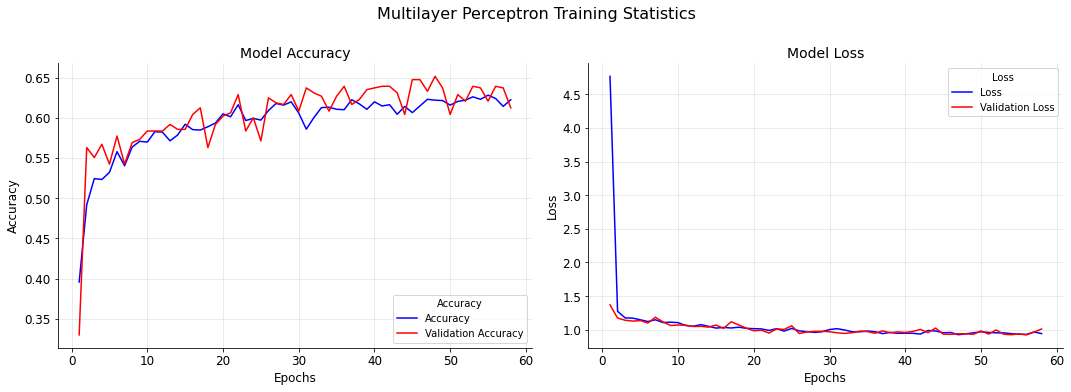

In [ ]:
training_process_viz(pd.DataFrame(mlp_train_history.history), 
                     plot_title = 'Multilayer Perceptron Training Statistics')

#### **8.1.4 Confusion Matrix for Multi-Layer Perceptron Based Model**

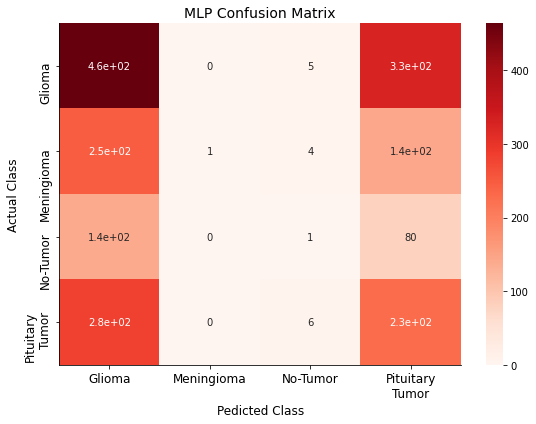

In [ ]:
confusion_matrix_viz(mlp_model, train_dataset, plot_title = "MLP Confusion Matrix")

In [ ]:
mlp_report_df = generate_report(mlp_model, 
                                test_dataset = validation_dataset, 
                                row_indexes = ("Multi-Layer-Perceptron Model",))
mlp_report_df

33/33 [==============================] - 33s 991ms/step - loss: 0.9263 - accuracy: 0.6243


,MAE,MSE,RMSE,Loss,Accuracy,F1-Score
Multi-Layer-Perceptron Model,1.39499,3.533719,1.879819,0.926313,0.624277,0.368979


### **8.2 AlexNet CNN**

#### **8.2.1 Develoment of AlexNet CNN Model**

In [ ]:
alexnet_cnn = Sequential()
alexnet_cnn.add(Conv2D(96, kernel_size = 11, strides = 4, activation = 'relu', input_shape = (image_size, image_size, 3), name = 'Conv2D-1'))
alexnet_cnn.add(BatchNormalization(name = 'Batch-Normalization-1'))
alexnet_cnn.add(MaxPool2D(pool_size = 3, strides = 2, name = 'Max-Pooling-1'))
alexnet_cnn.add(Conv2D(256, kernel_size = 5, padding = 'same', activation = 'relu', name = 'Conv2D-2'))
alexnet_cnn.add(BatchNormalization(name = 'Batch-Normalization-2'))
alexnet_cnn.add(MaxPool2D(pool_size = 3, strides = 2, name = 'Max-Pooling-2'))
alexnet_cnn.add(Conv2D(384, kernel_size = 3, padding = 'same', activation = 'relu', name = 'Conv2D-3'))
alexnet_cnn.add(BatchNormalization(name = 'Batch-Normalization-3'))
alexnet_cnn.add(Conv2D(384, kernel_size = 3, padding = 'same', activation = 'relu', name = 'Conv2D-4'))
alexnet_cnn.add(BatchNormalization(name = 'Batch-Normalization-4'))
alexnet_cnn.add(Conv2D(256, kernel_size = 3, padding = 'same', activation = 'relu', name = 'Conv2D-5'))
alexnet_cnn.add(BatchNormalization(name = 'Batch-Normalization-5'))
alexnet_cnn.add(MaxPool2D(pool_size = 3, strides = 2, name = 'Max-Pooling-3'))
alexnet_cnn.add(Flatten(name = 'Flatten-Layer-1'))
alexnet_cnn.add(Dense(128, activation = 'relu', name = 'Hidden-Layer-1'))
alexnet_cnn.add(Dropout(rate = 0.5, name = 'Dropout-Layer-1'))
alexnet_cnn.add(Dense(64, activation = 'relu', name = 'Hidden-Layer-2'))
alexnet_cnn.add(Dropout(rate = 0.5, name = 'Dropout-Layer-2'))
alexnet_cnn.add(Dense(4, activation = 'softmax', name = 'Output-Layer'))
alexnet_cnn.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
alexnet_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D-1 (Conv2D)            (None, 30, 30, 96)        34944     
_________________________________________________________________
Batch-Normalization-1 (Batch (None, 30, 30, 96)        384       
_________________________________________________________________
Max-Pooling-1 (MaxPooling2D) (None, 14, 14, 96)        0         
_________________________________________________________________
Conv2D-2 (Conv2D)            (None, 14, 14, 256)       614656    
_________________________________________________________________
Batch-Normalization-2 (Batch (None, 14, 14, 256)       1024      
_________________________________________________________________
Max-Pooling-2 (MaxPooling2D) (None, 6, 6, 256)         0         
_________________________________________________________________
Conv2D-3 (Conv2D)            (None, 6, 6, 384)        

#### **8.2.2 Training and Validation of AlexNet CNN Model**

In [ ]:
alexnet_train_history = alexnet_cnn.fit(train_dataset, 
                                            batch_size = batch_size,
                                            validation_data = validation_dataset, 
                                            epochs = 100, 
                                            callbacks = [early_stopping, alexnet_cp_callback])

Epoch 1/100
61/61 [==============================] - 106s 1s/step - loss: 1.9368 - accuracy: 0.3745 - val_loss: 1.3511 - val_accuracy: 0.3361

Epoch 00001: saving model to gdrive/MyDrive/Deep_Learning_Course_Project/Model-Checkpoints/AlexNet-CNN
Epoch 2/100
61/61 [==============================] - 75s 1s/step - loss: 1.3039 - accuracy: 0.4236 - val_loss: 1.4838 - val_accuracy: 0.2701

Epoch 00002: saving model to gdrive/MyDrive/Deep_Learning_Course_Project/Model-Checkpoints/AlexNet-CNN
Epoch 3/100
61/61 [==============================] - 75s 1s/step - loss: 1.2819 - accuracy: 0.4396 - val_loss: 1.4569 - val_accuracy: 0.2825

Epoch 00003: saving model to gdrive/MyDrive/Deep_Learning_Course_Project/Model-Checkpoints/AlexNet-CNN
Epoch 4/100
61/61 [==============================] - 75s 1s/step - loss: 1.2649 - accuracy: 0.4824 - val_loss: 1.2596 - val_accuracy: 0.4433

Epoch 00004: saving model to gdrive/MyDrive/Deep_Learning_Course_Project/Model-Checkpoints/AlexNet-CNN
Epoch 5/100
61/61 [

#### **8.2.3 AlexNet CNN Model Training Process Statistics**

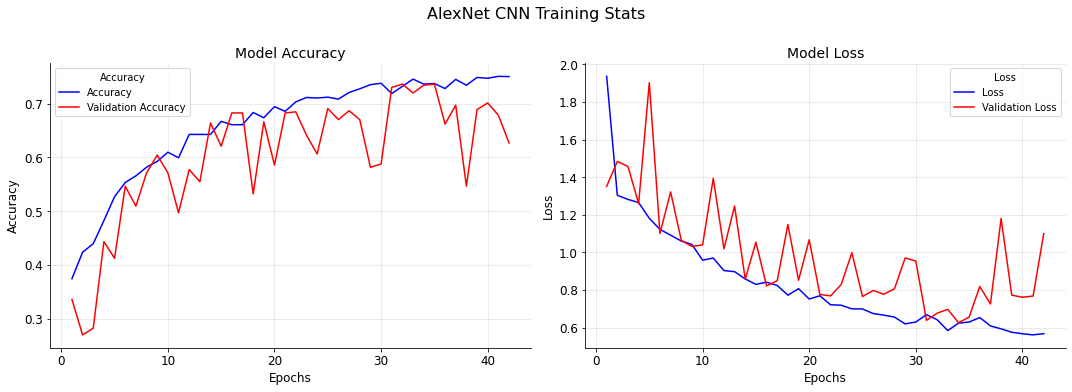

In [ ]:
training_process_viz(pd.DataFrame(alexnet_train_history.history), plot_title = 'AlexNet CNN Training Stats')

#### **8.2.4 Confusion Matrix for AlexNet CNN Model**

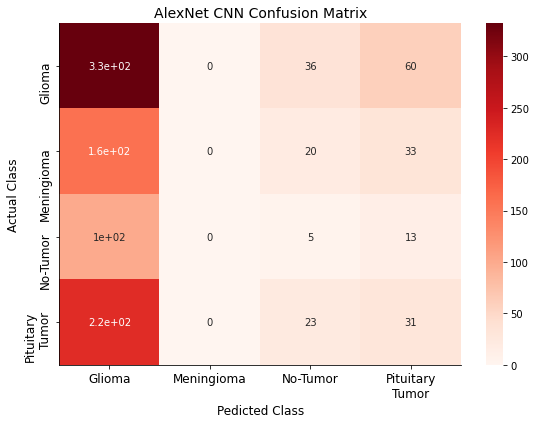

In [ ]:
confusion_matrix_viz(alexnet_cnn, 
                         train_dataset, 
                         plot_title = "AlexNet CNN Confusion Matrix")

In [ ]:
alexnet_report_df = generate_report(alexnet_cnn, test_dataset = validation_dataset, row_indexes = ['AlexNet CNN'])
alexnet_report_df

33/33 [==============================] - 33s 988ms/step - loss: 1.1357 - accuracy: 0.6079


,MAE,MSE,RMSE,Loss,Accuracy,F1-Score
AlexNet CNN,1.301541,3.205202,1.790308,1.135692,0.6079,0.382466


### **8.3 ResNet CNN**

#### **8.3.1 Develoment of ResNet CNN Model**

In [ ]:
alexnet_cnn = Sequential()
alexnet_cnn.add(Conv2D(96, kernel_size = 11, strides = 4, activation = 'relu', input_shape = (image_size, image_size, 3), name = 'Conv2D-1'))
alexnet_cnn.add(BatchNormalization(name = 'Batch-Normalization-1'))
alexnet_cnn.add(MaxPool2D(pool_size = 3, strides = 2, name = 'Max-Pooling-1'))
alexnet_cnn.add(Conv2D(256, kernel_size = 5, padding = 'same', activation = 'relu', name = 'Conv2D-2'))
alexnet_cnn.add(BatchNormalization(name = 'Batch-Normalization-2'))
alexnet_cnn.add(MaxPool2D(pool_size = 3, strides = 2, name = 'Max-Pooling-2'))
alexnet_cnn.add(Conv2D(384, kernel_size = 3, padding = 'same', activation = 'relu', name = 'Conv2D-3'))
alexnet_cnn.add(BatchNormalization(name = 'Batch-Normalization-3'))
alexnet_cnn.add(Conv2D(384, kernel_size = 3, padding = 'same', activation = 'relu', name = 'Conv2D-4'))
alexnet_cnn.add(BatchNormalization(name = 'Batch-Normalization-4'))
alexnet_cnn.add(Conv2D(256, kernel_size = 3, padding = 'same', activation = 'relu', name = 'Conv2D-5'))
alexnet_cnn.add(BatchNormalization(name = 'Batch-Normalization-5'))
alexnet_cnn.add(MaxPool2D(pool_size = 3, strides = 2, name = 'Max-Pooling-3'))
alexnet_cnn.add(Flatten(name = 'Flatten-Layer-1'))
alexnet_cnn.add(Dense(128, activation = 'relu', name = 'Hidden-Layer-1'))
alexnet_cnn.add(Dropout(rate = 0.5, name = 'Dropout-Layer-1'))
alexnet_cnn.add(Dense(64, activation = 'relu', name = 'Hidden-Layer-2'))
alexnet_cnn.add(Dropout(rate = 0.5, name = 'Dropout-Layer-2'))
alexnet_cnn.add(Dense(4, activation = 'softmax', name = 'Output-Layer'))
alexnet_cnn.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
alexnet_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D-1 (Conv2D)            (None, 30, 30, 96)        34944     
_________________________________________________________________
Batch-Normalization-1 (Batch (None, 30, 30, 96)        384       
_________________________________________________________________
Max-Pooling-1 (MaxPooling2D) (None, 14, 14, 96)        0         
_________________________________________________________________
Conv2D-2 (Conv2D)            (None, 14, 14, 256)       614656    
_________________________________________________________________
Batch-Normalization-2 (Batch (None, 14, 14, 256)       1024      
_________________________________________________________________
Max-Pooling-2 (MaxPooling2D) (None, 6, 6, 256)         0         
_________________________________________________________________
Conv2D-3 (Conv2D)            (None, 6, 6, 384)        

#### **8.3.2 Training and Validation of ResNet CNN Model**

In [ ]:
alexnet_train_history = alexnet_cnn.fit(train_dataset, 
                                            batch_size = batch_size,
                                            validation_data = validation_dataset, 
                                            epochs = 100, 
                                            callbacks = [early_stopping, alexnet_cp_callback])

Epoch 1/100
61/61 [==============================] - 106s 1s/step - loss: 1.9368 - accuracy: 0.3745 - val_loss: 1.3511 - val_accuracy: 0.3361

Epoch 00001: saving model to gdrive/MyDrive/Deep_Learning_Course_Project/Model-Checkpoints/AlexNet-CNN
Epoch 2/100
61/61 [==============================] - 75s 1s/step - loss: 1.3039 - accuracy: 0.4236 - val_loss: 1.4838 - val_accuracy: 0.2701

Epoch 00002: saving model to gdrive/MyDrive/Deep_Learning_Course_Project/Model-Checkpoints/AlexNet-CNN
Epoch 3/100
61/61 [==============================] - 75s 1s/step - loss: 1.2819 - accuracy: 0.4396 - val_loss: 1.4569 - val_accuracy: 0.2825

Epoch 00003: saving model to gdrive/MyDrive/Deep_Learning_Course_Project/Model-Checkpoints/AlexNet-CNN
Epoch 4/100
61/61 [==============================] - 75s 1s/step - loss: 1.2649 - accuracy: 0.4824 - val_loss: 1.2596 - val_accuracy: 0.4433

Epoch 00004: saving model to gdrive/MyDrive/Deep_Learning_Course_Project/Model-Checkpoints/AlexNet-CNN
Epoch 5/100
61/61 [

#### **8.3.3 ResNet CNN Model Training Process Statistics**

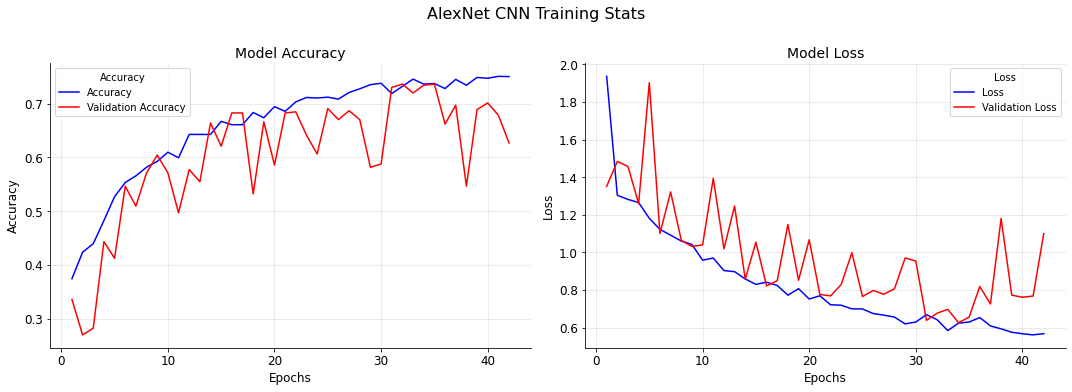

In [ ]:
training_process_viz(pd.DataFrame(alexnet_train_history.history), plot_title = 'AlexNet CNN Training Stats')

#### **8.3.4 Confusion Matrix for resNet CNN Model**

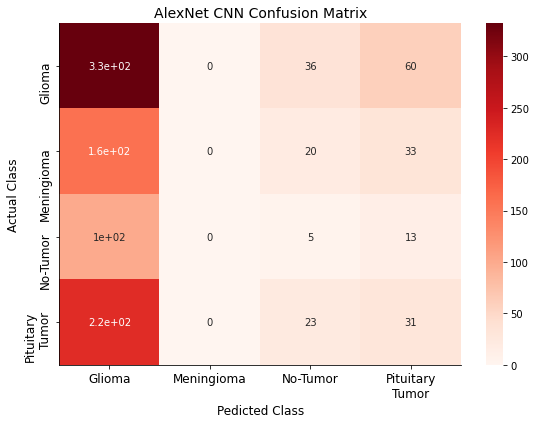

In [ ]:
confusion_matrix_viz(alexnet_cnn, 
                         train_dataset, 
                         plot_title = "ResNet CNN Confusion Matrix")

In [ ]:
resnet_report_df = generate_report(resnet_cnn, test_dataset = validation_dataset, row_indexes = ['ResNet CNN'])
resnet_report_df

33/33 [==============================] - 33s 988ms/step - loss: 1.1357 - accuracy: 0.6079


,MAE,MSE,RMSE,Loss,Accuracy,F1-Score
AlexNet CNN,1.301541,3.205202,1.790308,1.135692,0.6079,0.382466


## **9. Conclusions**

* The **pre-trained (imagenet) InceptionV3** model has performed the best among Multi-Layer perceptron and AlexNet CNN models with an accuracy of $82.57\%$ (Refer the following table).

In [ ]:
final_report_df = pd.concat([mlp_report_df, alexnet_report_df, resnet_report_df])
final_report_df

,MAE,MSE,RMSE,Loss,Accuracy,F1-Score
Multi-Layer-Perceptron Model,1.394990,3.533719,1.879819,0.926313,0.624277,0.368979
AlexNet CNN,1.301541,3.205202,1.790308,1.135692,0.607900,0.382466
InceptionV3,1.365125,3.101156,1.761010,0.452249,0.825626,0.284200
